In [1]:
import os
import pandas as pd

# Define dataset path
dataset_path = "/kaggle/input/class-data/class-data"

# Severity mapping (folder names)
severity_levels = ["VERY LOW", "LOW", "MEDIUM", "HIGH"]

# Collect audio file paths and labels
data = []
for severity in severity_levels:
    severity_path = os.path.join(dataset_path, severity)
    
    if os.path.exists(severity_path):  # Check if folder exists
        for file in os.listdir(severity_path):
            if file.endswith(".wav"):
                file_path = os.path.join(severity_path, file)
                data.append((file_path, severity))

# Create DataFrame
df = pd.DataFrame(data, columns=["file_path", "severity"])

# Save metadata as CSV for future reference
df.to_csv("dataset_metadata.csv", index=False)

# Display sample data
print(f"✅ Found {len(df)} audio files.")
print(df.head())


✅ Found 11437 audio files.
                                           file_path  severity
0  /kaggle/input/class-data/class-data/VERY LOW/M...  VERY LOW
1  /kaggle/input/class-data/class-data/VERY LOW/M...  VERY LOW
2  /kaggle/input/class-data/class-data/VERY LOW/M...  VERY LOW
3  /kaggle/input/class-data/class-data/VERY LOW/M...  VERY LOW
4  /kaggle/input/class-data/class-data/VERY LOW/F...  VERY LOW


In [2]:
!pip install librosa numpy pandas tqdm matplotlib scikit-learn tensorflow -q

100%|██████████| 11437/11437 [10:32<00:00, 18.09it/s]


✅ All spectrograms saved as .npy files.


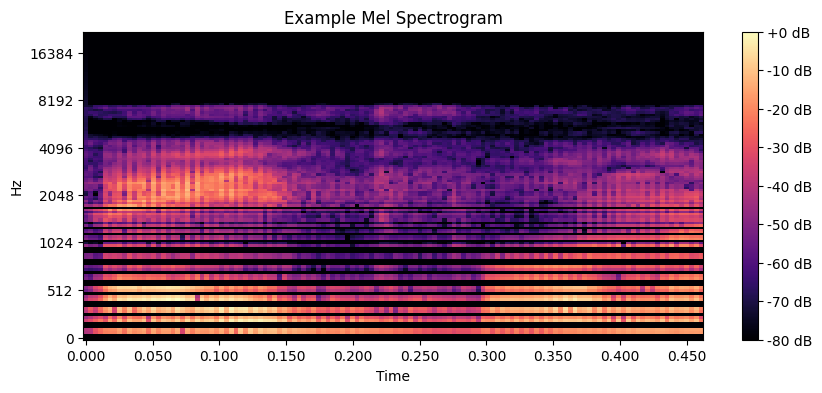

In [5]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define parameters
SAMPLE_RATE = 44100  # Standard for speech processing
N_MELS = 128         # Number of mel bands
N_FFT = 400          # FFT window size
HOP_LENGTH = 160     # Hop length for frame shifting
T_MAX = 128          # Fixed time steps for all spectrograms

# Output directory for spectrograms
spectrogram_folder = "spectrograms_npy"
os.makedirs(spectrogram_folder, exist_ok=True)

# Function to convert audio to mel spectrogram
def process_audio(file_path):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Trim silence
        y, _ = librosa.effects.trim(y, top_db=25)

        # Convert to mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)

        # Convert to log scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        return mel_spec_db
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

# Process all audio files
for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row["file_path"]
    mel_spec = process_audio(file_path)

    if mel_spec is not None:
        # Pad or truncate spectrogram to fixed size
        if mel_spec.shape[1] < T_MAX:
            pad_width = T_MAX - mel_spec.shape[1]
            mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode="constant")
        else:
            mel_spec = mel_spec[:, :T_MAX]

        # Save as .npy file
        np.save(os.path.join(spectrogram_folder, f"{idx}.npy"), mel_spec)

print("✅ All spectrograms saved as .npy files.")


# Verify one sample
example_spec = np.load(os.path.join(spectrogram_folder, "0.npy"))
plt.figure(figsize=(10, 4))
librosa.display.specshow(example_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Example Mel Spectrogram")
plt.show()

In [6]:
import shutil

# Define the folder to zip and the output zip file name
folder_to_zip = "/kaggle/working/spectrograms_npy"  # Change this to your folder
output_zip = "/kaggle/working/spectrograms_npy.zip"

# Zip the folder
shutil.make_archive(output_zip.replace(".zip", ""), 'zip', folder_to_zip)

print(f"Zipped folder saved as: {output_zip}")

Zipped folder saved as: /kaggle/working/spectrograms_npy.zip


In [7]:
from IPython.display import FileLink

# Create and display a download link
FileLink("/kaggle/working/spectrograms_npy.zip")

/kaggle/working/spectrograms_npy.zip

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Reload dataset metadata
df = pd.read_csv("dataset_metadata.csv")

severity_mapping = {"VERY LOW": 0, "LOW": 1, "MEDIUM": 2, "HIGH": 3}
df["severity"] = df["severity"].map(severity_mapping)

# Function to load .npy spectrogram
def load_spectrogram(idx):
    file_path = os.path.join(spectrogram_folder, f"{idx}.npy")
    return np.load(file_path) if os.path.exists(file_path) else None

# Load spectrograms and labels
X, y = [], []
for idx, row in df.iterrows():
    spec = load_spectrogram(idx)
    if spec is not None:
        X.append(spec)
        y.append(row["severity"])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape for model input (add channel dimension)
X = np.expand_dims(X, axis=-1)  # Shape: (samples, mel, time, channels)

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"✅ Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

✅ Training Samples: 9149, Testing Samples: 2288


In [12]:
# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"✅ Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

✅ Training Samples: 9149, Testing Samples: 2288


In [14]:
print(df.dtypes)

file_path    object
severity      int64
dtype: object


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Model Parameters
INPUT_SHAPE = (128, 128, 1)  # Mel spectrogram shape (Mel bands, Time steps, Channels)
NUM_CLASSES = 4  # Dysarthria severity levels: VERY LOW, LOW, MEDIUM, HIGH

# Residual Block with Shortcut Projection
def residual_block(x, filters):
    shortcut = x  # Store the original input

    # First Conv Layer
    x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Second Conv Layer
    x = layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut dimension if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding="same")(shortcut)

    # Merge the residual connection
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Multi-Head Attention Block
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, num_heads, embed_dim):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

    def call(self, inputs):
        return self.mha(inputs, inputs)

# Model Architecture
def build_model():
    inputs = Input(shape=INPUT_SHAPE)

    # CNN Feature Extraction
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Residual Blocks
    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten before Attention
    x = layers.Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)

    # Multi-Head Attention
    x = MultiHeadSelfAttention(num_heads=4, embed_dim=128)(x)

    # Global Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Output for Dysarthria Severity Classification
    severity_output = layers.Dense(NUM_CLASSES, activation="softmax", name="severity")(x)

    # Create Model
    model = Model(inputs, outputs=severity_output)

    return model

# Build Model
model = build_model()
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 32)   │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128, 128, 32)   │            128 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 32)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 64, 64, 64)     │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 64, 64, 64)     │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 64)     │          2,112 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 64, 64)     │              0 │ batch_normalization_7… │
│                           │                        │                │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 64)     │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 32, 32, 64)     │              0 │ re_lu_2[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 32, 32, 128)    │            512 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9

 Total params: 553,604 (2.11 MB)

 Trainable params: 552,772 (2.11 MB)

 Non-trainable params: 832 (3.25 KB)

In [18]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16
)

# Save trained model
model.save("dysarthria_rescnn_mha.h5")
print("✅ Model training complete and saved!")


Epoch 1/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.4537 - loss: 1.2118 - val_accuracy: 0.5070 - val_loss: 1.2047
Epoch 2/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5918 - loss: 0.9487 - val_accuracy: 0.3195 - val_loss: 2.6363
Epoch 3/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.6866 - loss: 0.7673 - val_accuracy: 0.6119 - val_loss: 1.1488
Epoch 4/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7439 - loss: 0.6288 - val_accuracy: 0.6954 - val_loss: 0.8080
Epoch 5/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7763 - loss: 0.5503 - val_accuracy: 0.6132 - val_loss: 1.0766
Epoch 6/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7877 - loss: 0.5126 - val_accuracy: 0.7583 - val_loss: 0.6079
Epoch 7/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.8194 - loss: 0.4520 - val_accuracy: 0.7806 - val_loss: 0.5093
Epoch 8/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8251 - loss: 0.4266 - 

In [19]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8405 - loss: 0.5260
✅ Test Accuracy: 84.13%


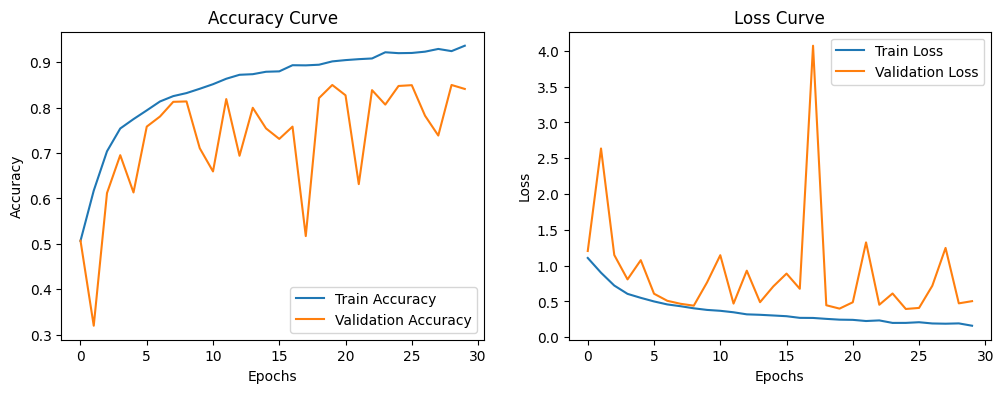

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy Plot
    axes[0].plot(history.history["accuracy"], label="Train Accuracy")
    axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[0].set_title("Accuracy Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    # Loss Plot
    axes[1].plot(history.history["loss"], label="Train Loss")
    axes[1].plot(history.history["val_loss"], label="Validation Loss")
    axes[1].set_title("Loss Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.show()

# Call function
plot_training_history(history)